In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import networkx as nx
from pathlib import Path
import sqlite3

In [2]:
# choose platform that you are currently working on
#plattform = "colab"
plattform = "jupyter"

In [3]:
if plattform == "colab":
  !pip install -U kaleido
  !pip install sknw

In [4]:
# choose path 
path_append = "D:/Documents/Studium/Uni_Osnabrück/WiSe22_23/Master_Thesis/Data/"
if plattform == "colab":
  path_append = "drive/MyDrive/"

In [5]:
if plattform == "colab":
  from google.colab import drive
  drive.mount('/content/drive')

In [6]:
# read participant data from csv
tracking_data = pd.read_csv(path_append + "coordinates_old.csv")

In [7]:
path_radius = os.path.join("D:/Documents/Studium/Uni_Osnabrück/WiSe22_23/Master_Thesis/Data/NodesRadius/")
radius_list = pd.read_csv(path_radius + "node_radius_final_Meli.csv", index_col=0)

In [8]:
tracking_data["x"] = tracking_data["x"].round(2)
tracking_data["z"] = tracking_data["z"].round(2)

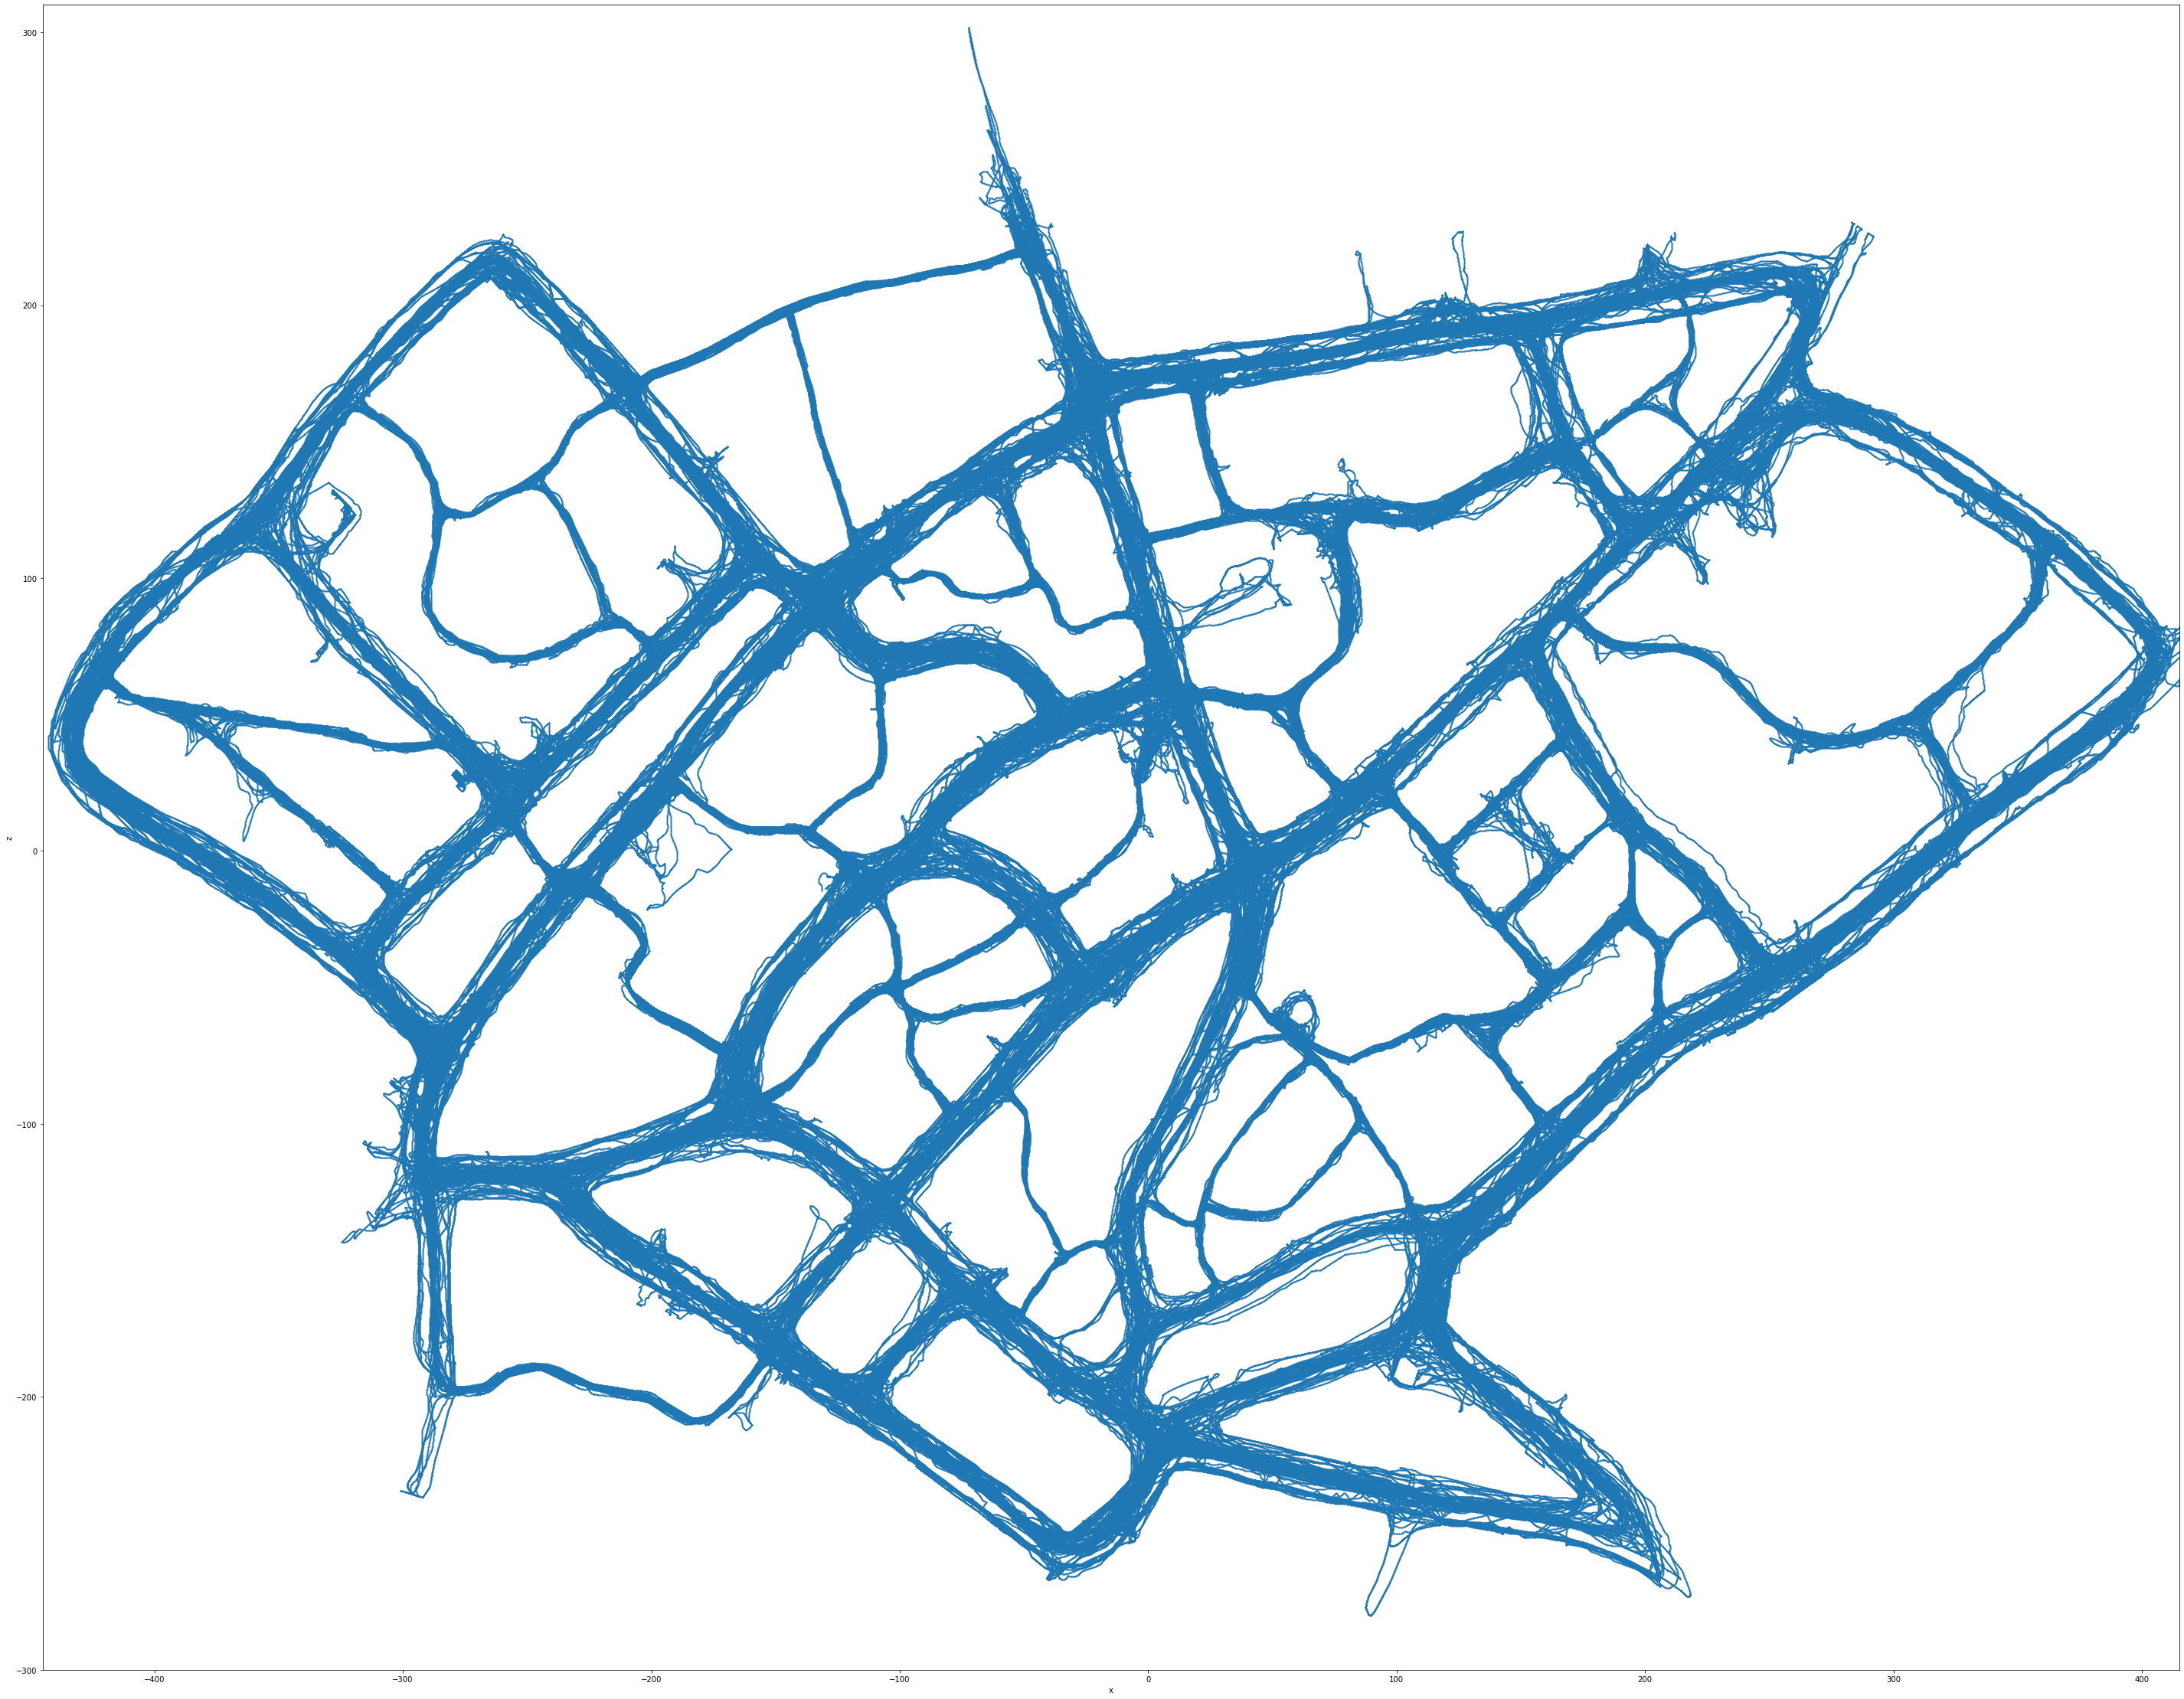

In [9]:
#density plot of location of participants 
scatter_plt = tracking_data.drop_duplicates().plot.scatter(x='x',
                      y='z',
                      xlim=[-445,415],
                      ylim=[-300,310],
                      s=0.1,
                      figsize=(50,40),
                      #c='time',
                      colormap='viridis')

In [10]:
xmin = tracking_data["x"].min()
xmax = tracking_data["x"].max()
zmin = tracking_data["z"].min()
zmax = tracking_data["z"].max()
print(tracking_data["x"].min())
print(tracking_data["x"].max())
print(tracking_data["z"].min())
print(tracking_data["z"].max())

-442.87
439.76
-280.14
301.68


In [11]:
def create_density_matrix(coordinates, meters):
    xmin = coordinates["x"].min()
    xmax = coordinates["x"].max()
    zmin = coordinates["z"].min()
    zmax = coordinates["z"].max()
    step = meters
    xsize = int((np.abs(xmin) + np.abs(xmax)) / step) + 1
    zsize = int((np.abs(zmin) + np.abs(zmax)) / step) + 1
    density_matrix = np.zeros((xsize,zsize), dtype=np.int64)
    i = 0
    for coordinate in coordinates[["x", "z"]].to_numpy():
        x = int((np.abs(xmin) + coordinate[0]) / step)
        y = int((np.abs(zmin) + coordinate[1]) / step)
        density_matrix[x,y] += 1
        i += 1
    return density_matrix

In [12]:
def convert_coordinate(coordinate, meters):
    step = meters
    xsize = int((np.abs(xmin) + np.abs(xmax)) / step) + 1
    zsize = int((np.abs(zmin) + np.abs(zmax)) / step) + 1
    x = int((np.abs(xmin) + coordinate[0]) / step)
    y = int((np.abs(zmin) + coordinate[1]) / step)
    return x, y

In [13]:
def rotate_matrix(matrix):
    return np.rot90(np.flip(matrix, axis=0), k=-1)

In [14]:
density_matrix = create_density_matrix(coordinates=tracking_data, meters=4)

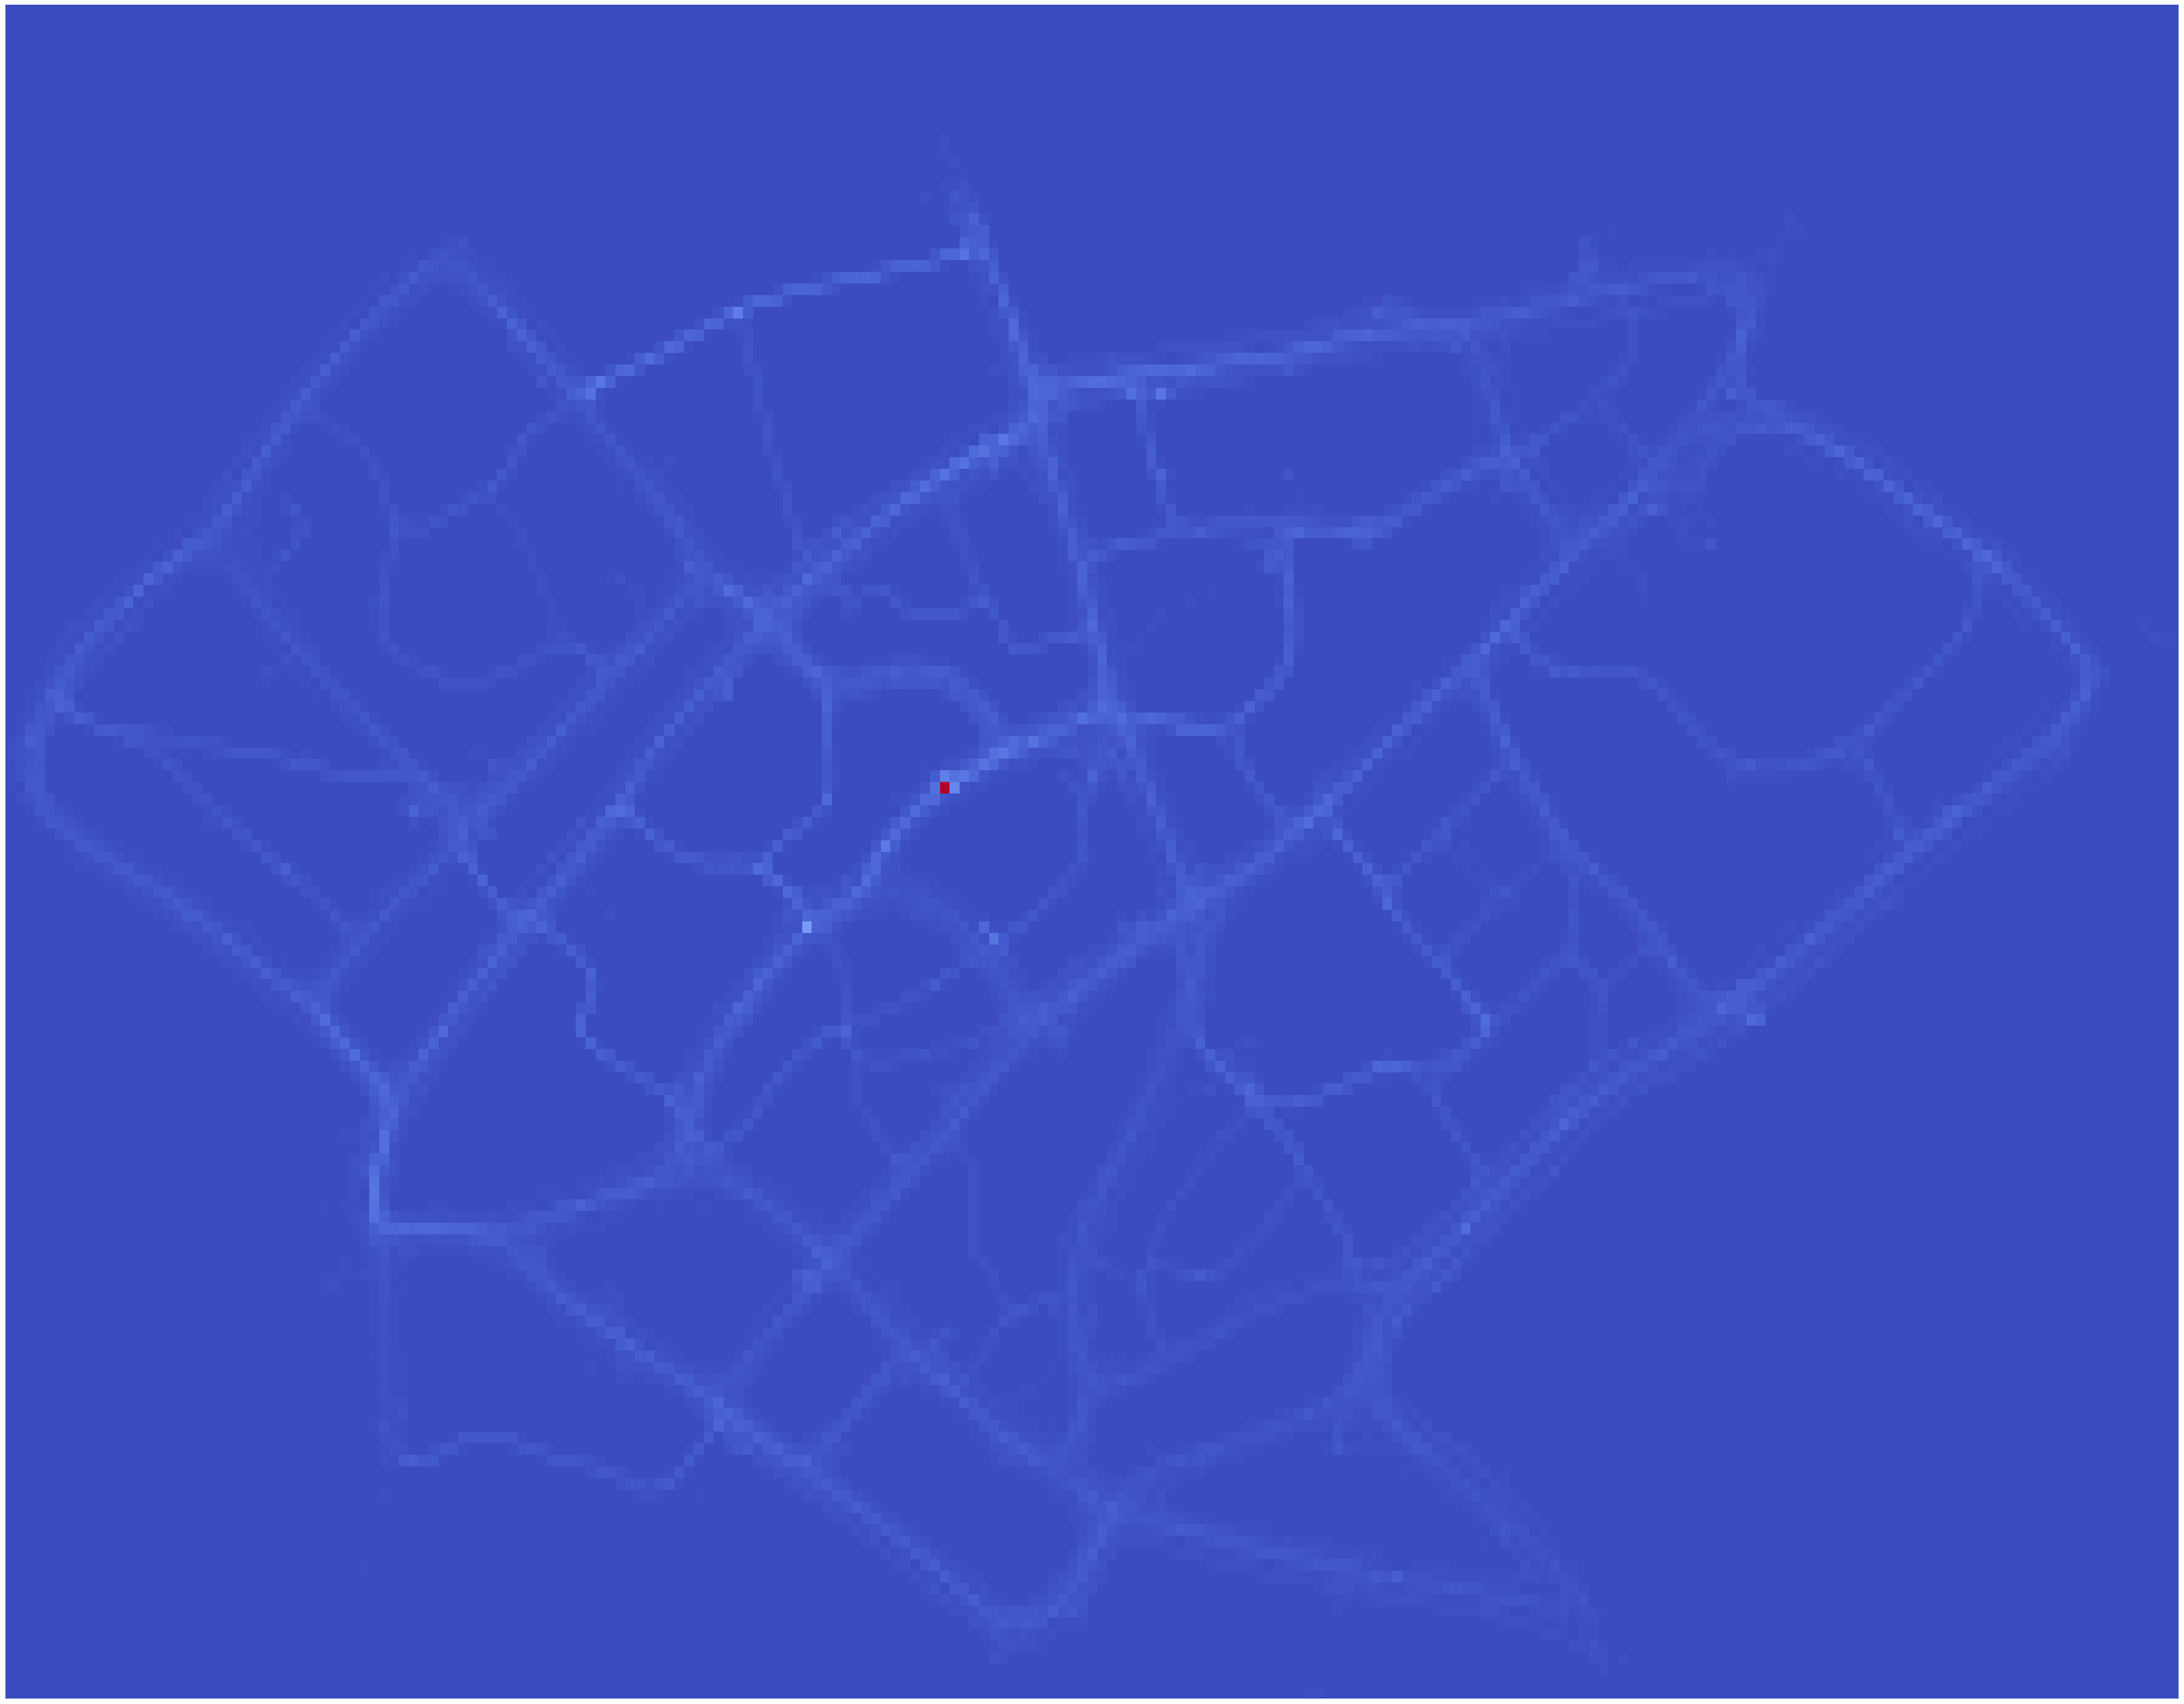

In [15]:
##density_matrix = create_density_matrix(coordinates=tracking_data, meters=4)
#rotated_matrix = rotate_matrix(density_matrix)
plt.figure(figsize=(50,40))
#heat_map = sns.heatmap(rotate_matrix(rotated_matrix), xticklabels=False, yticklabels=False, cmap='coolwarm', cbar=False)
heat_map = sns.heatmap(rotate_matrix(density_matrix), xticklabels=False, yticklabels=False, cmap='coolwarm', cbar=False)
plt.gca().invert_yaxis()
plt.show()

In [16]:
#plt.figure(figsize=(50,40))
#heat_map = sns.heatmap(density_matrix, xticklabels=False, yticklabels=False, cmap='coolwarm', cbar=False)
#plt.gca().invert_yaxis()
#plt.show()

In [17]:
mask = density_matrix.copy()
mask[mask <= 0] = 0
mask[mask > 0] = 1

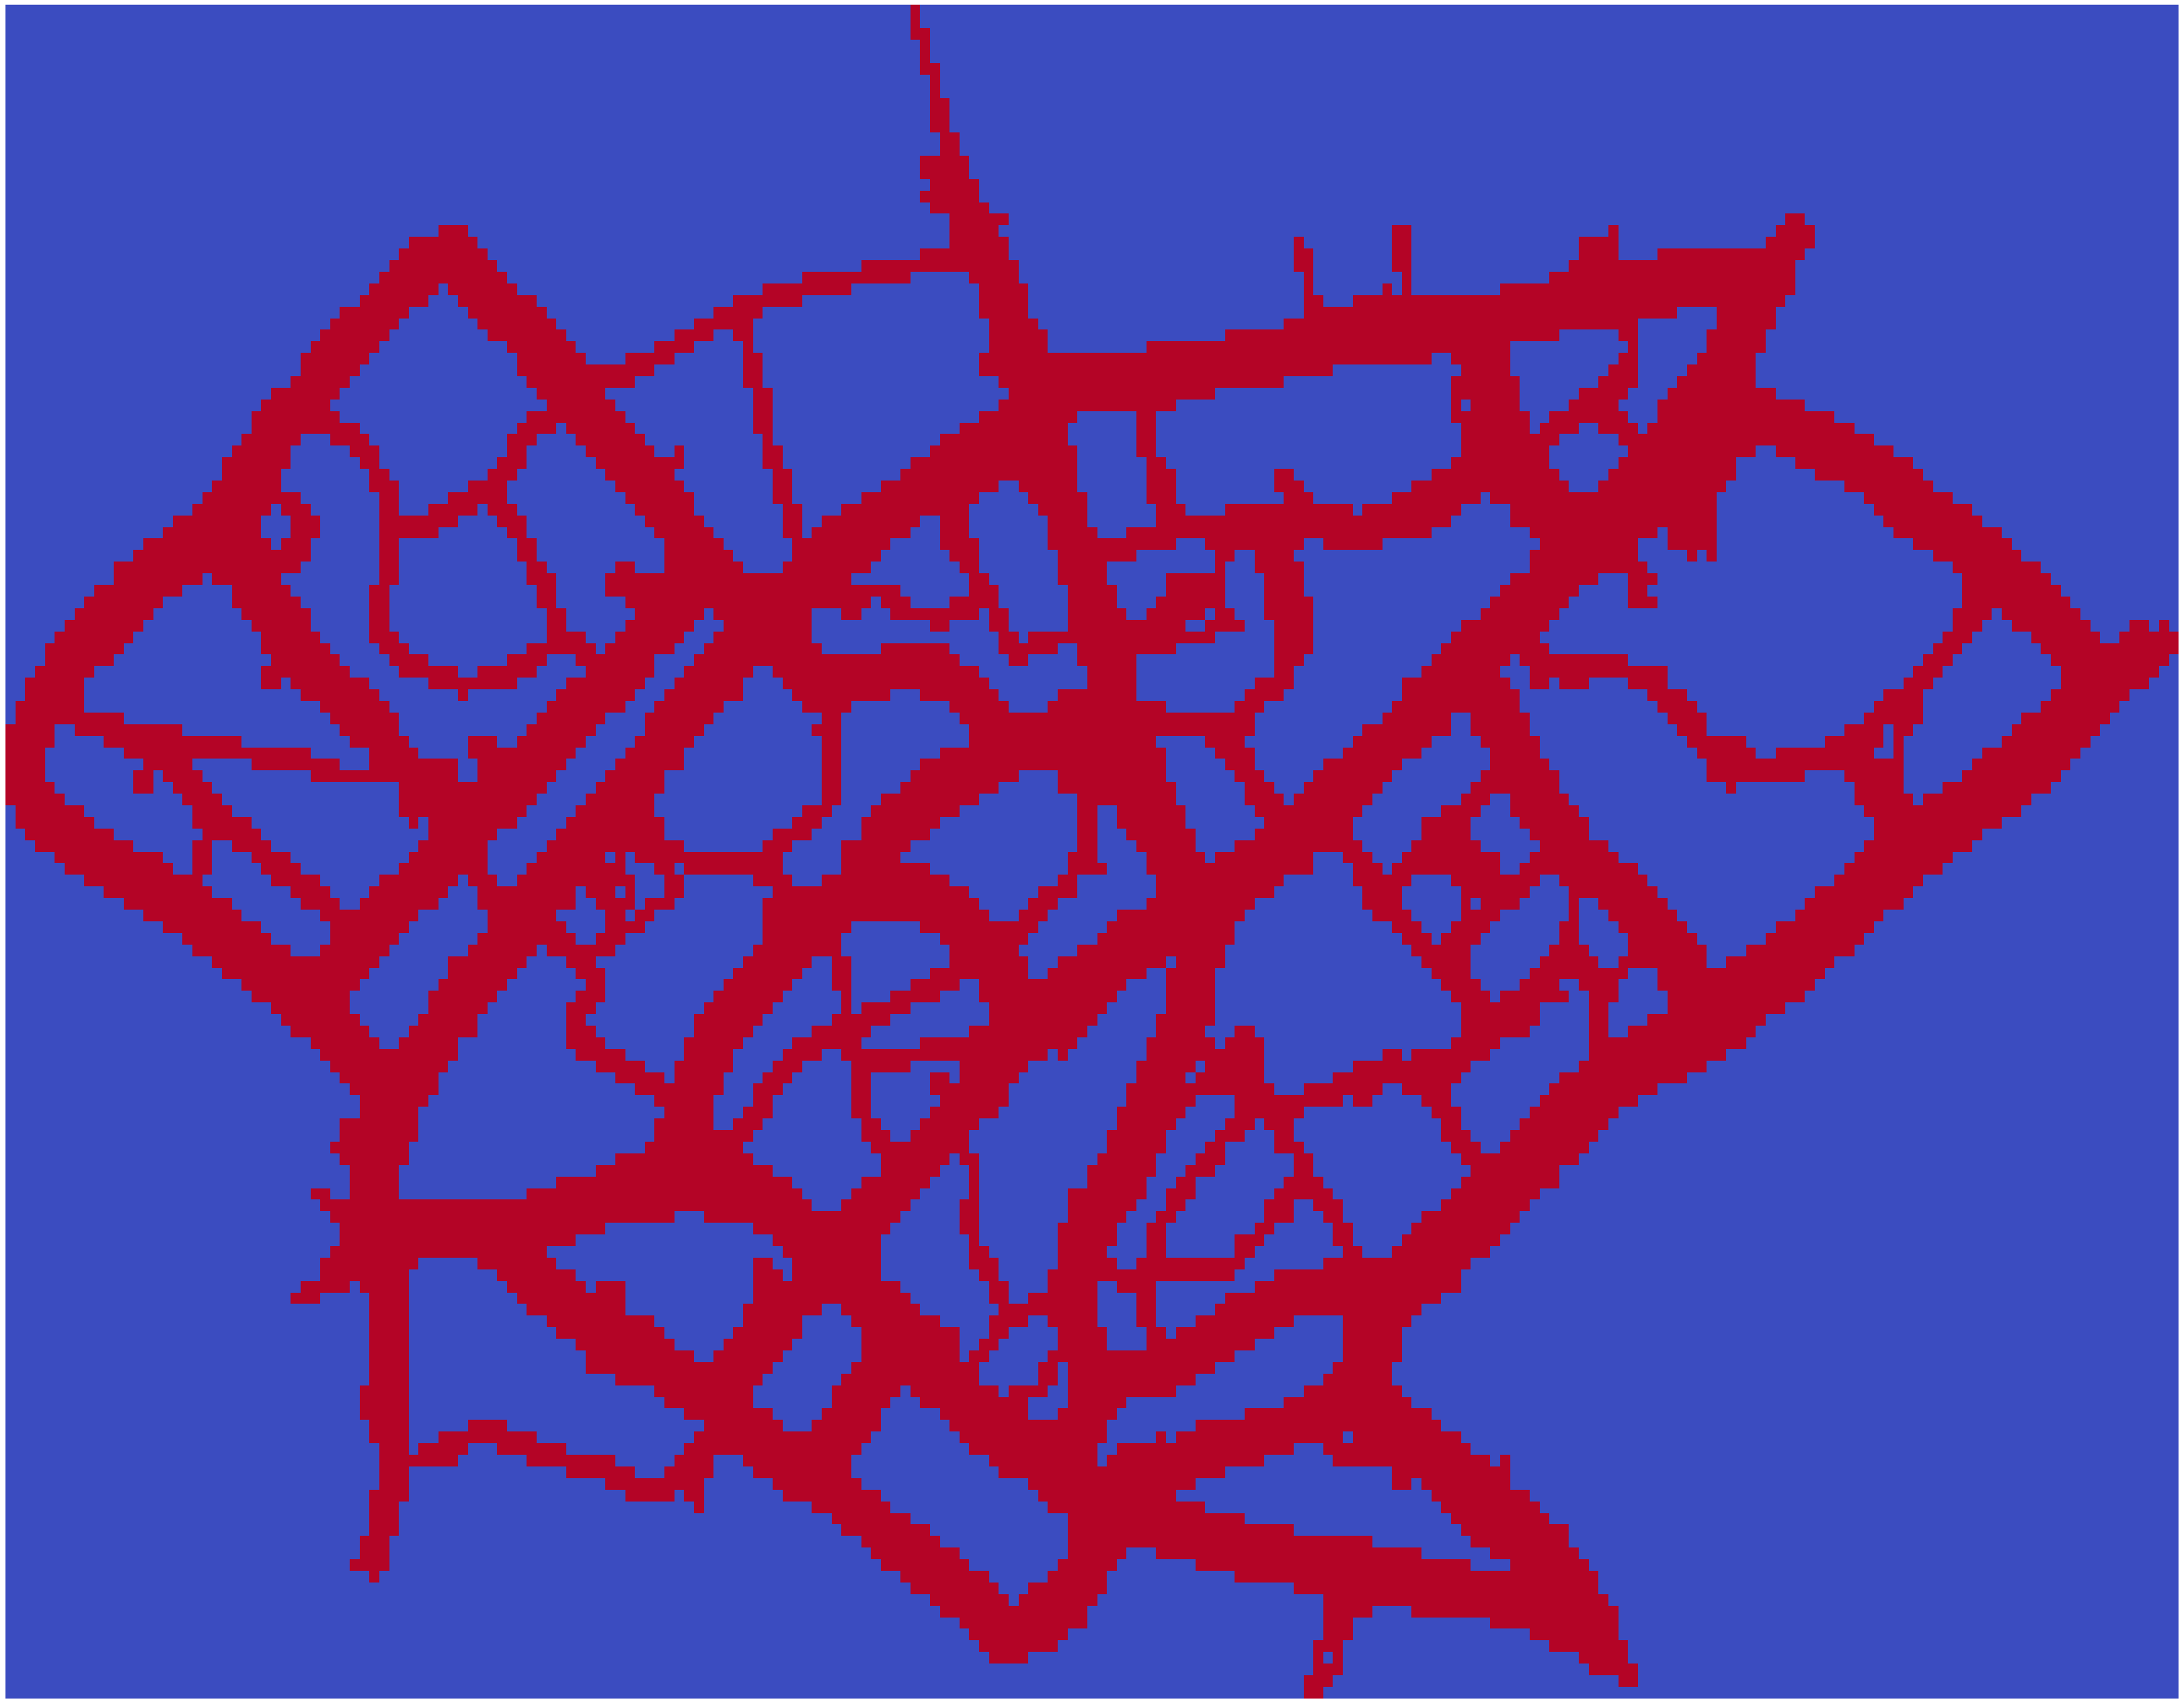

In [18]:
plt.figure(figsize=(50,40))
heat_map = sns.heatmap(rotate_matrix(mask), xticklabels=False, yticklabels=False, cmap='coolwarm', cbar=False)
plt.gca().invert_yaxis()
plt.show()

In [19]:
#mask = rotate_matrix(density_matrix.copy())
#mask[mask <= 0] = 0
#mask[mask > 0] = 1

In [20]:
#plt.figure(figsize=(50,40))
#heat_map = sns.heatmap(mask, xticklabels=False, yticklabels=False, cmap='coolwarm', cbar=False)
#plt.gca().invert_yaxis()
#plt.show()

In [21]:
def binary_fill(binary_matrix):
    for i in range(len(binary_matrix)):
        for j in range(len(binary_matrix[i])):
            if (i + 1 >= len(binary_matrix) or binary_matrix[i + 1][j] == 1) and (j + 1 >= len(binary_matrix[i]) or binary_matrix[i][j + 1] == 1) and (i - 1 < 0 or binary_matrix[i - 1][j] == 1) and (j - 1 < 0 or binary_matrix[i][j - 1] == 1):
                binary_matrix[i][j] = 1
    return binary_matrix

In [22]:
mask = binary_fill(mask)
#mask[120,92] = 1
#mask[121,92] = 1

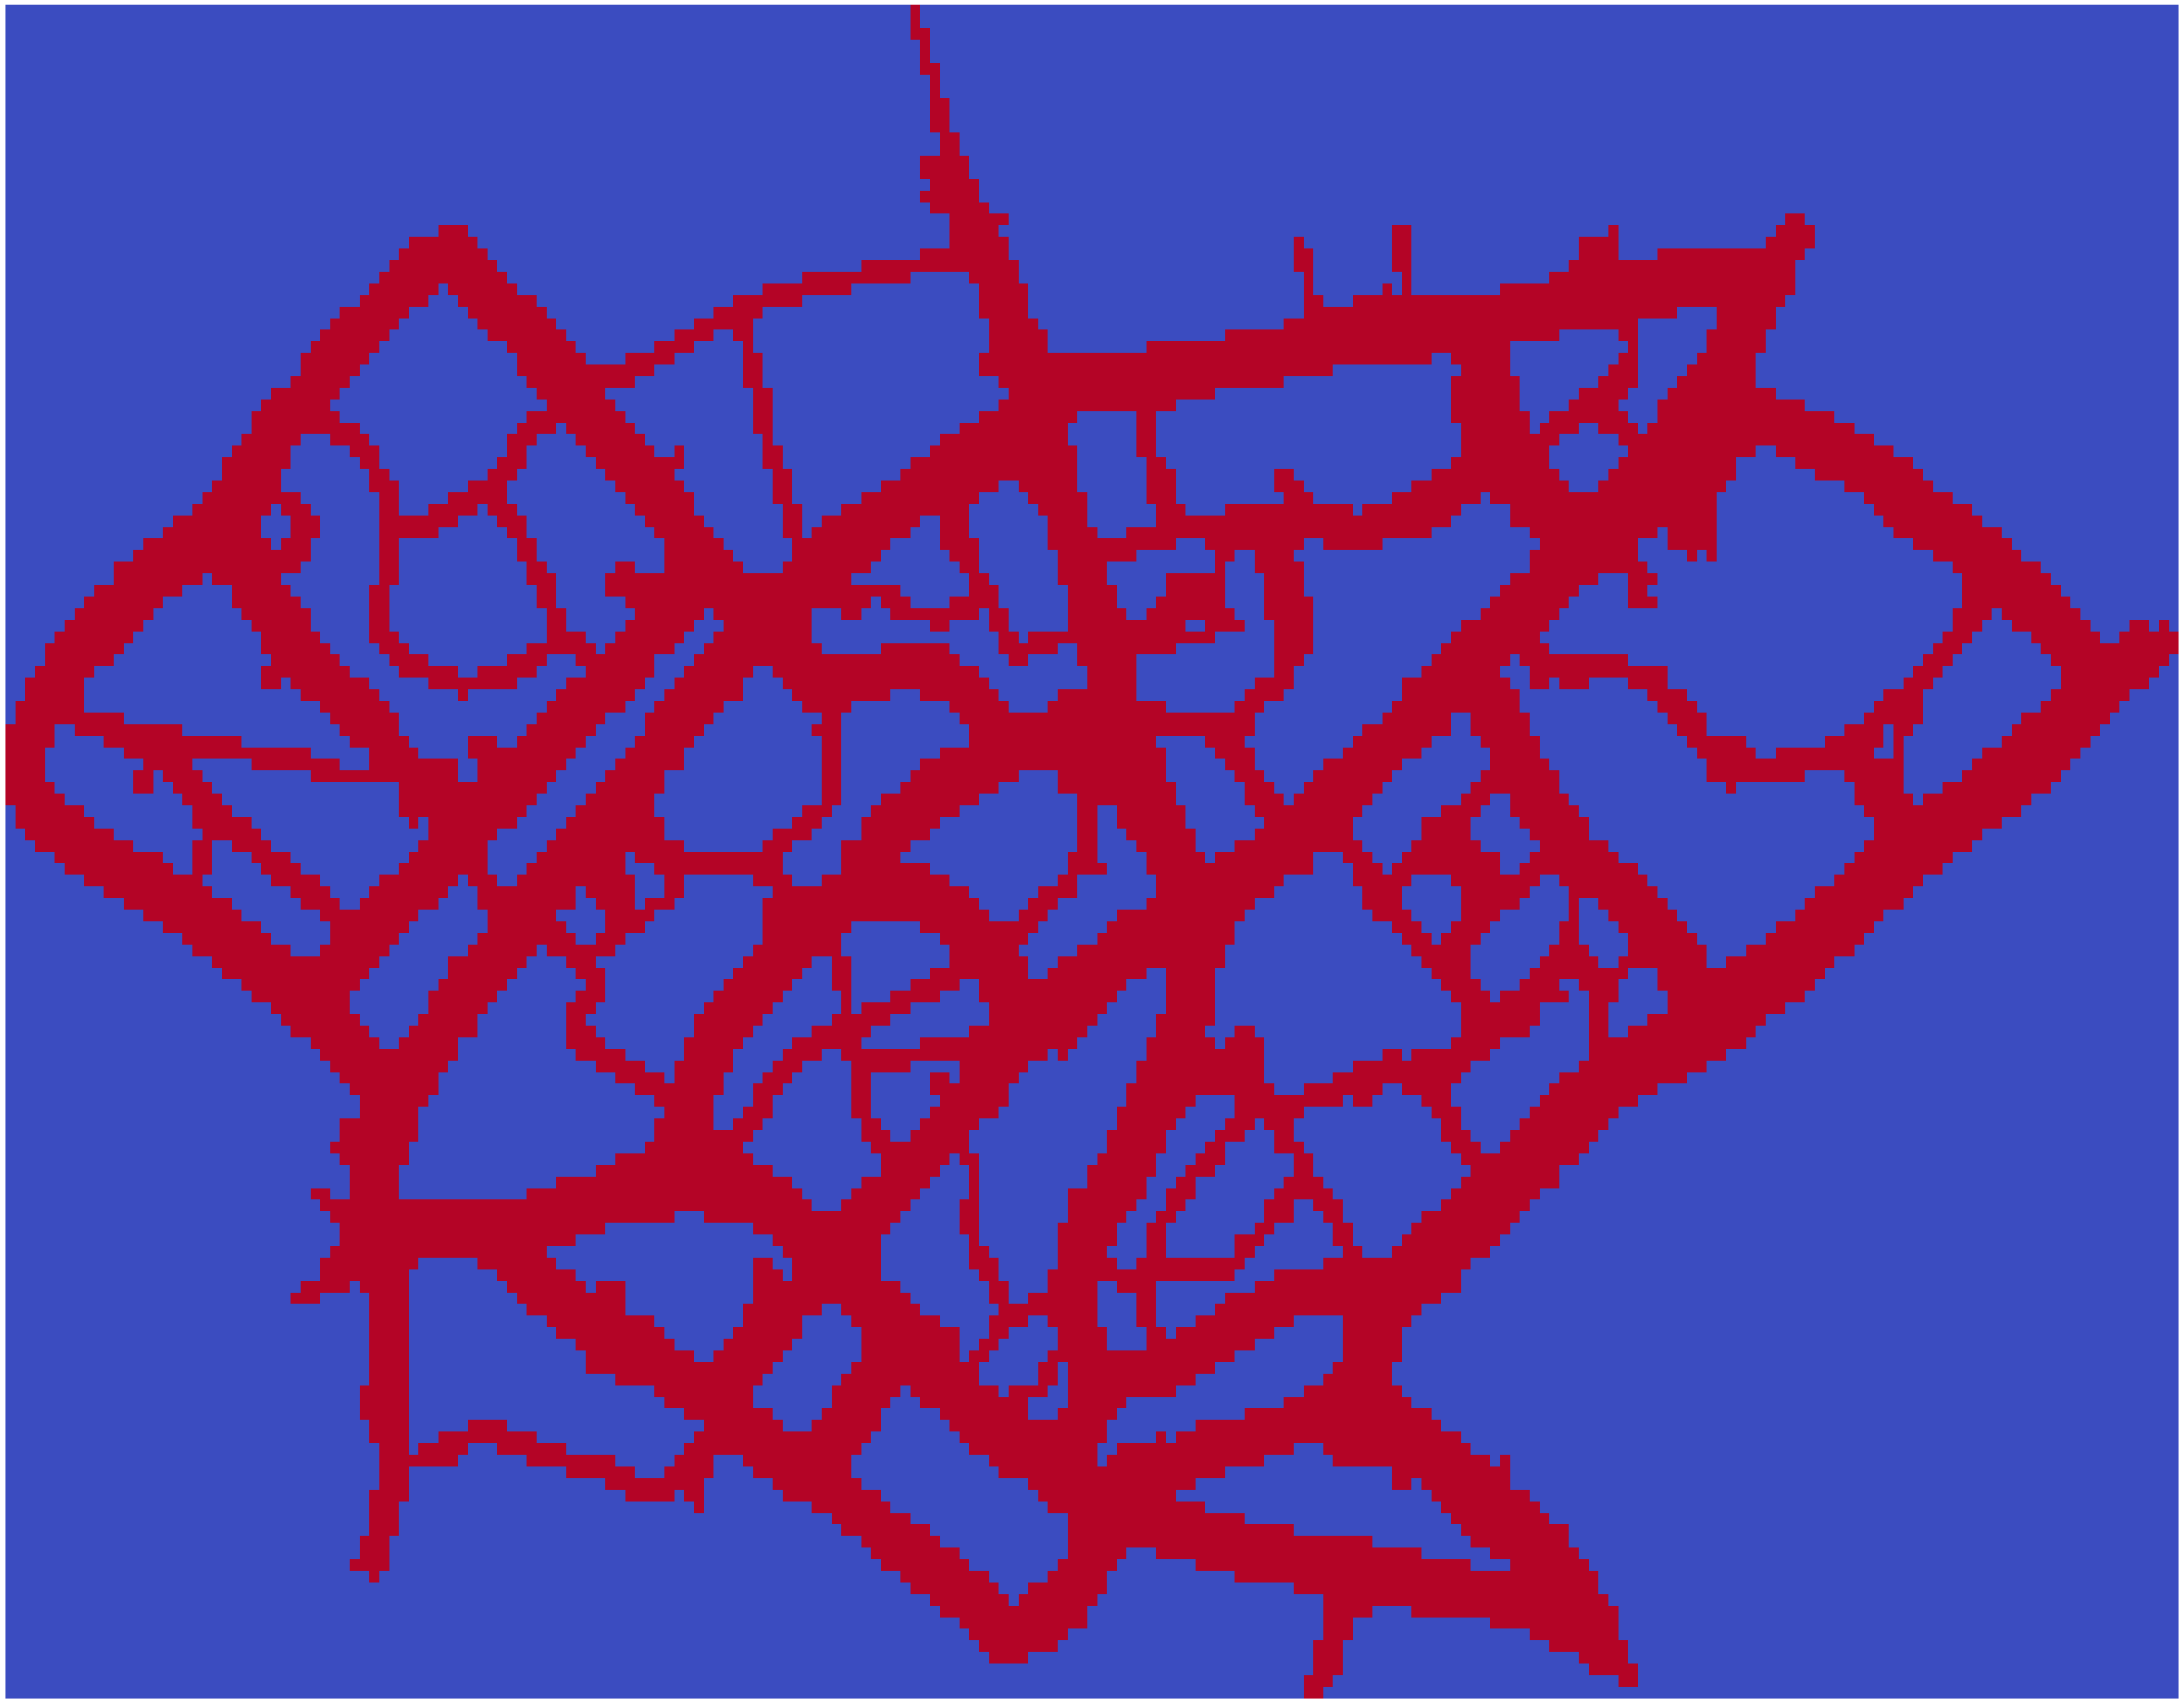

In [23]:
plt.figure(figsize=(50,40))
heat_map = sns.heatmap(rotate_matrix(mask), xticklabels=False, yticklabels=False, cmap='coolwarm', cbar=False)
plt.gca().invert_yaxis()
plt.show()

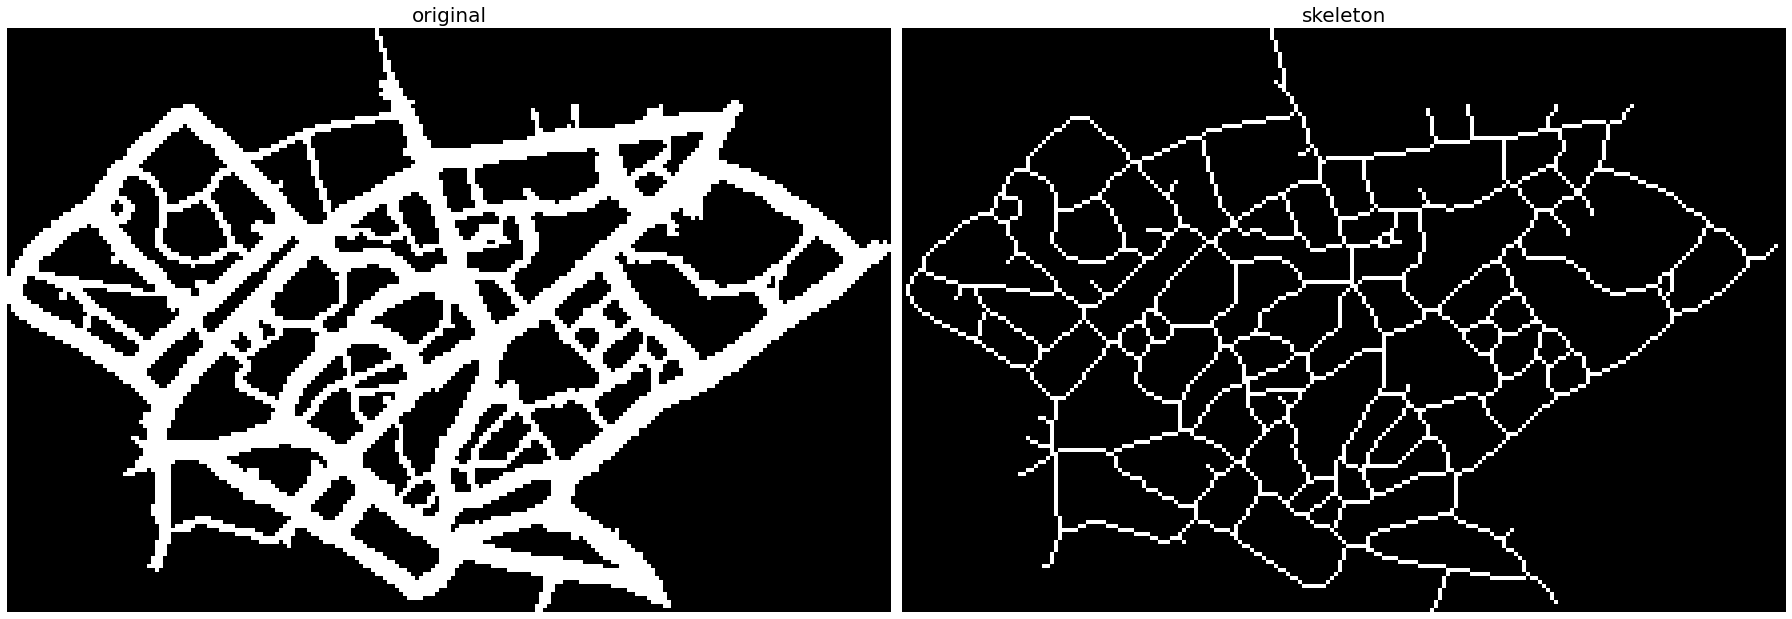

In [24]:
from skimage.morphology import skeletonize

skeleton = skeletonize(mask)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 20),
                         sharex=True, sharey=True)

ax = axes.ravel()

#ax[0].imshow(mask, cmap=plt.cm.gray)
ax[0].imshow(rotate_matrix(mask), cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

#ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].imshow(rotate_matrix(skeleton), cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.gca().invert_yaxis()
plt.show()

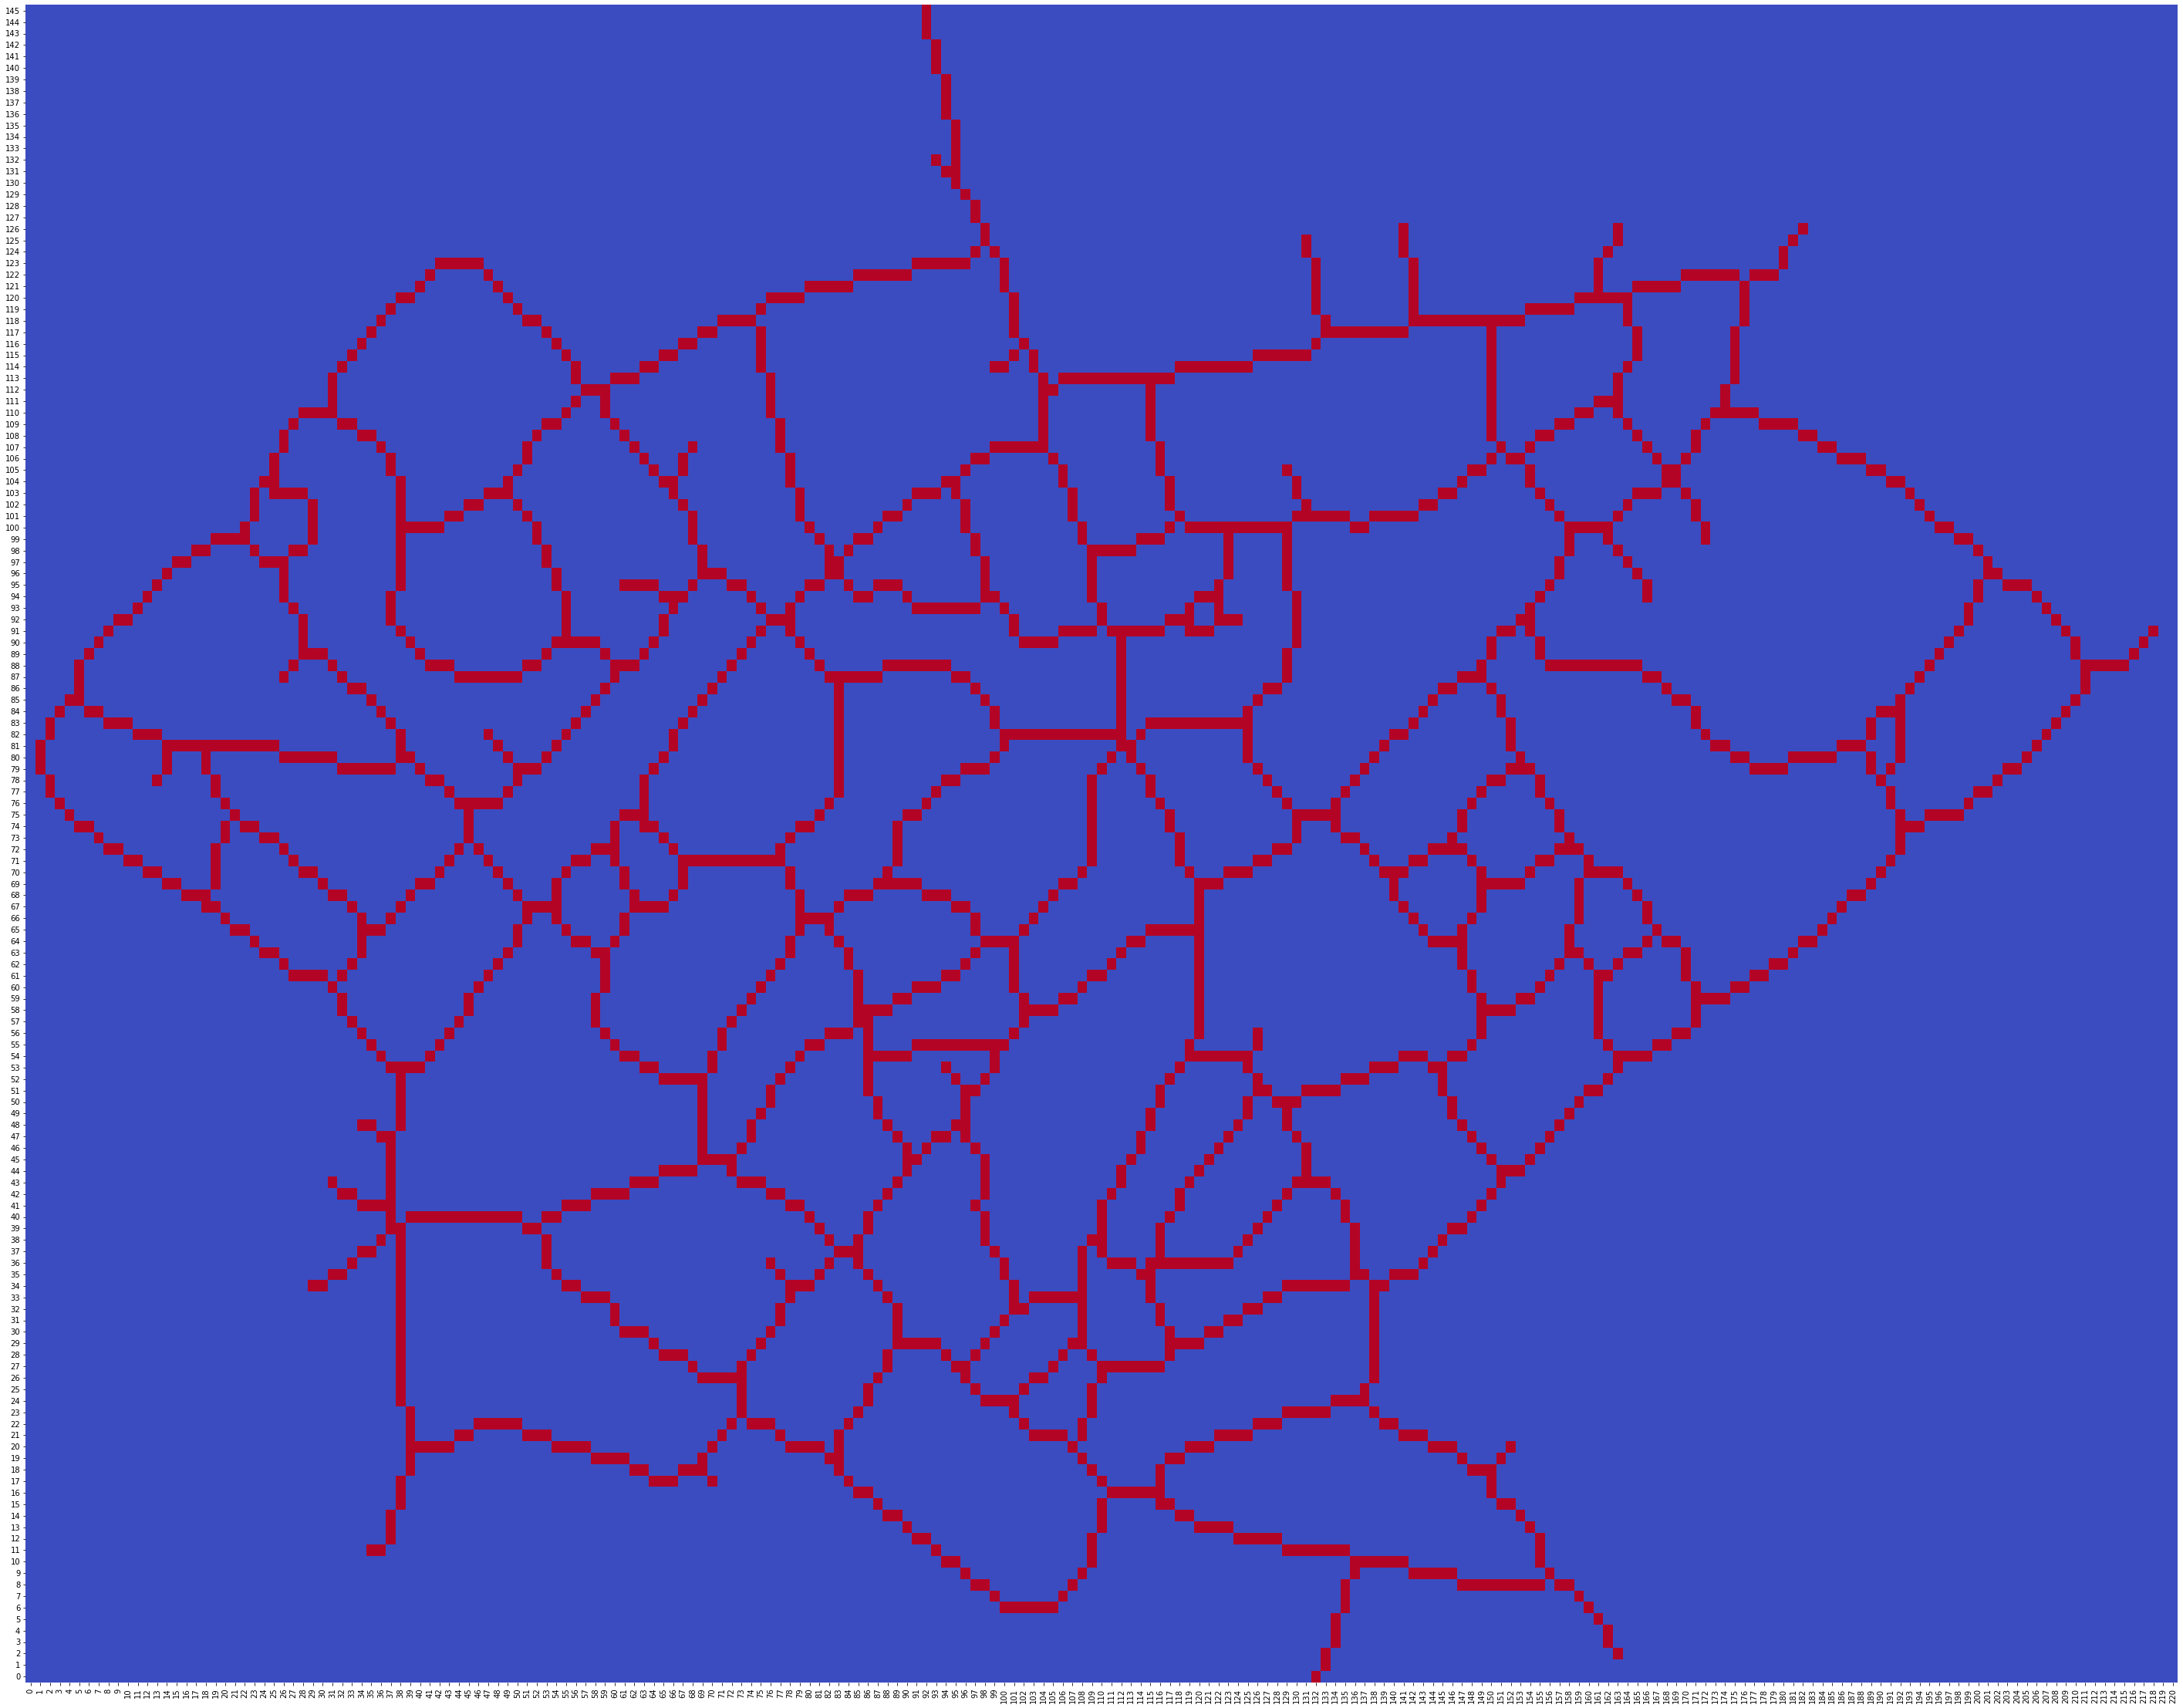

In [25]:
plt.figure(figsize=(50,40))
heat_map = sns.heatmap(rotate_matrix(skeleton), cmap='coolwarm', cbar=False)
plt.gca().invert_yaxis()
plt.show()

In [26]:
#plt.figure(figsize=(50,40))
#heat_map = sns.heatmap(skeleton, cmap='coolwarm', cbar=False)
#plt.gca().invert_yaxis()
#plt.show()

In [27]:
#sns.heatmap(mask)

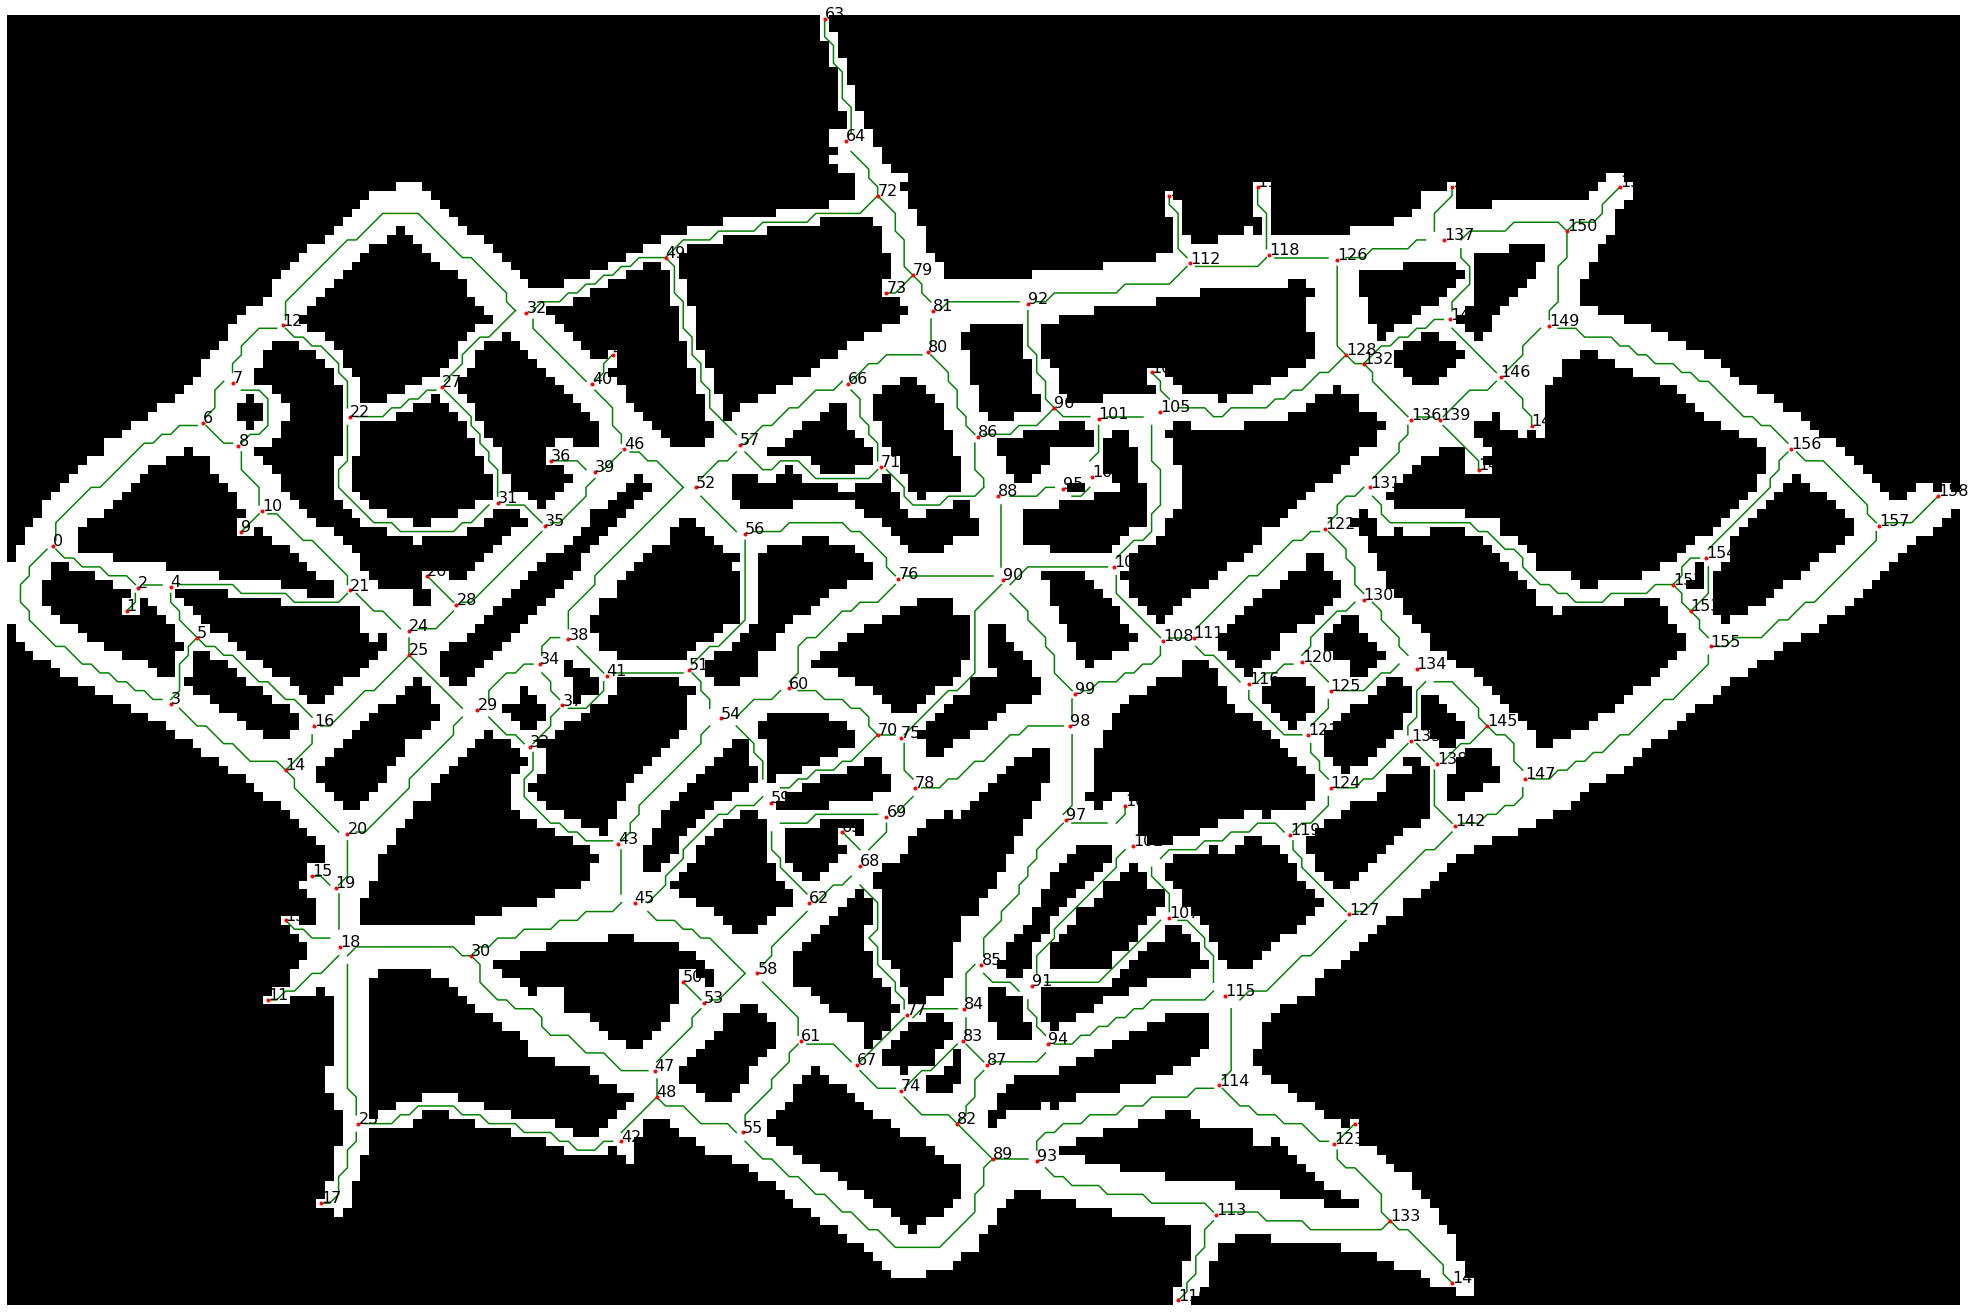

In [28]:
import sknw

empty_graph = sknw.build_sknw(skeleton)
nx.set_node_attributes(empty_graph, radius_list["Radius"], "r")

plt.figure(figsize=(35,50))
#plt.imshow(mask, cmap='gray')
plt.imshow(rotate_matrix(mask), cmap='gray')
plt.axis('off')

# draw edges by pts
for (s,e) in empty_graph.edges():
    ps = empty_graph[s][e]['pts']
    plt.plot(ps[:,0], ps[:,1], 'green')
    
# draw node by o
nodes = empty_graph.nodes()
for node in nodes:
    ps = nodes[node]['o']
    plt.text(ps[0] , ps[1], node, fontsize=16)
    plt.plot(ps[0], ps[1], 'r.')

# title and show
plt.gca().invert_yaxis()
plt.show()

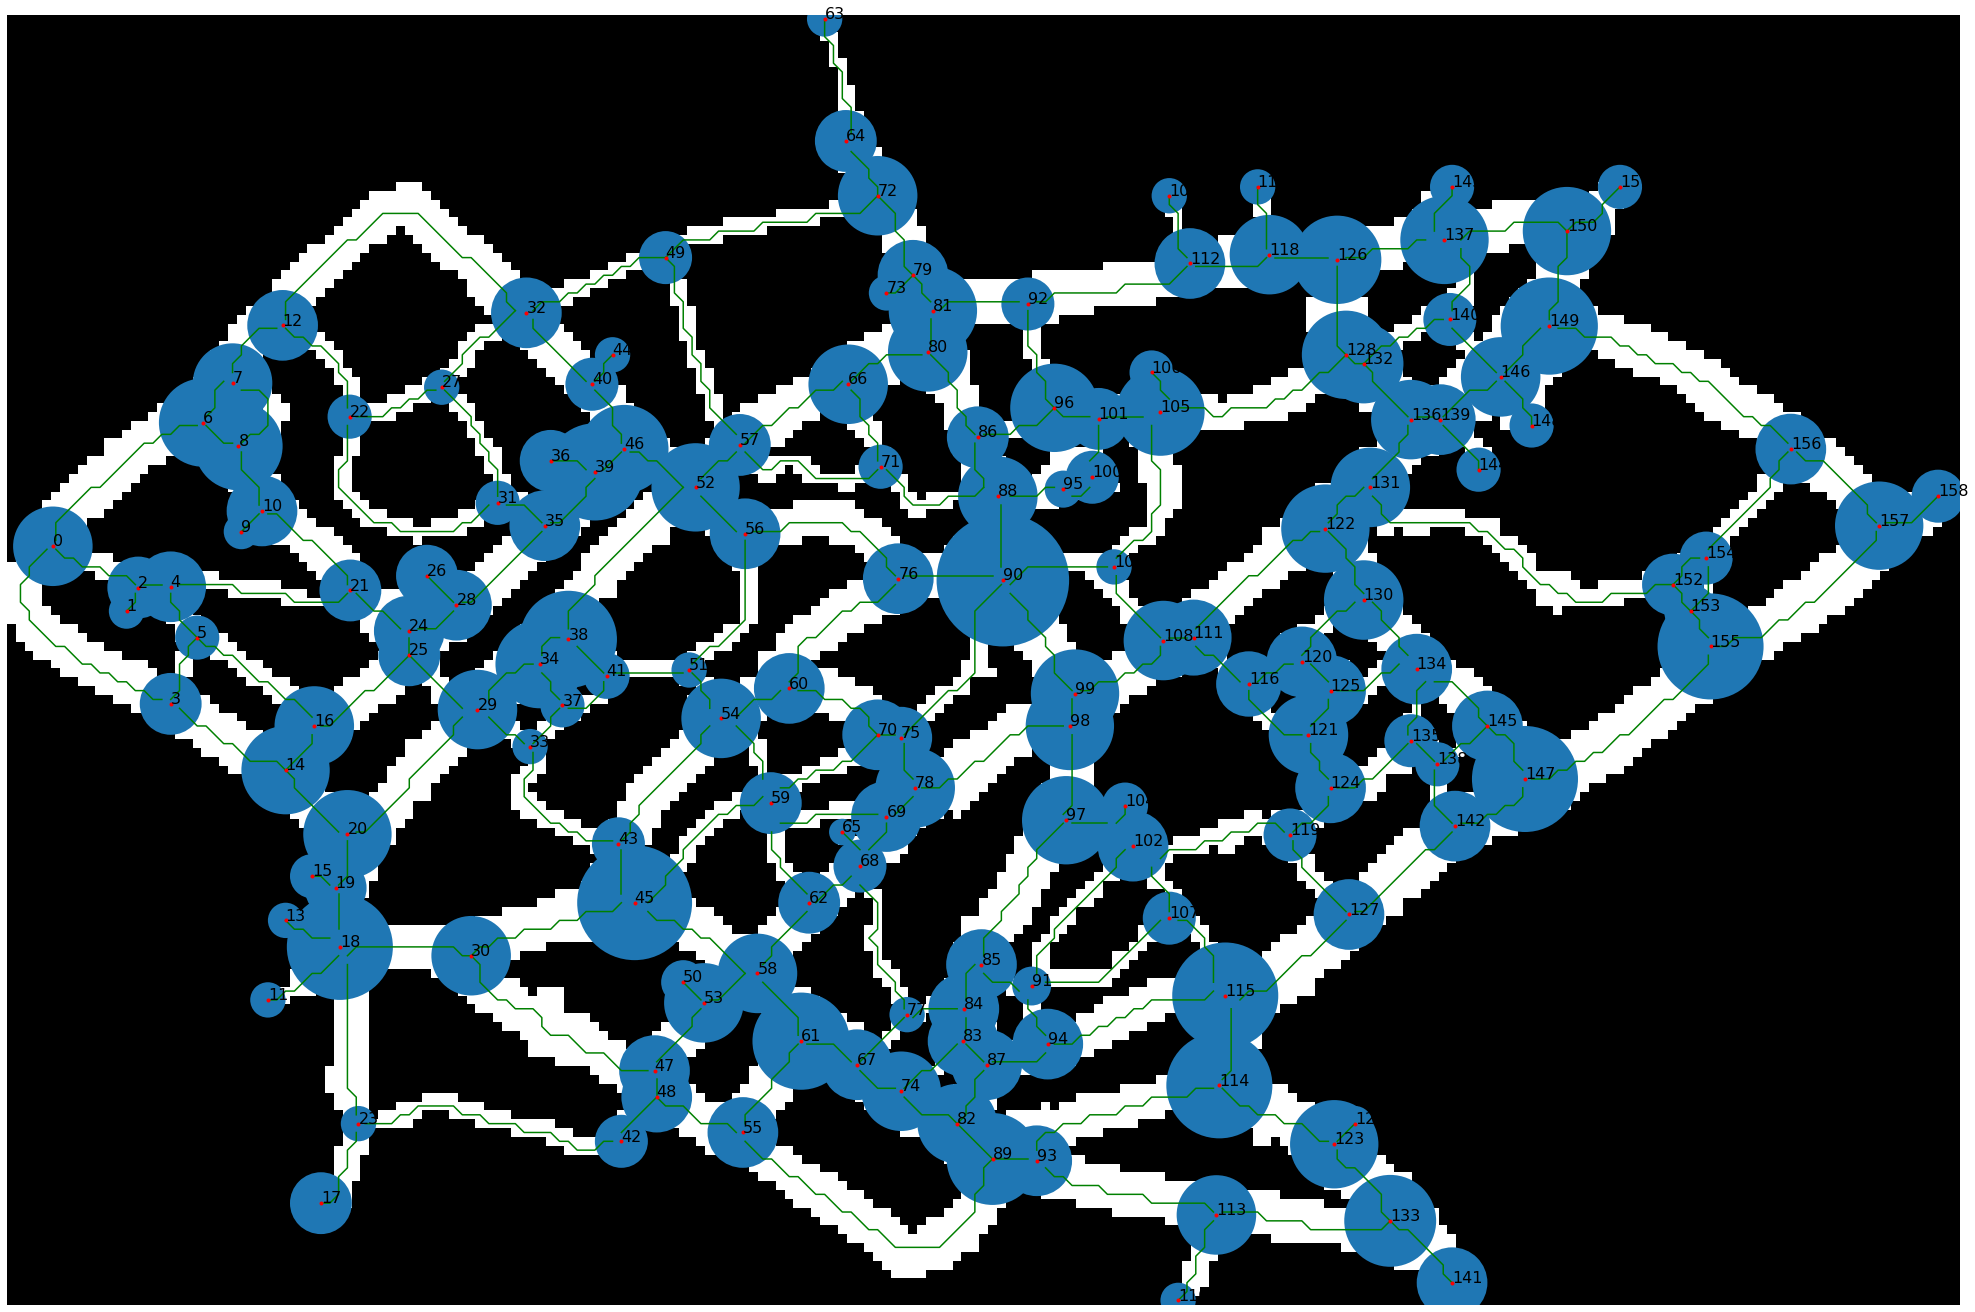

In [29]:
import sknw

empty_graph = sknw.build_sknw(skeleton)
nx.set_node_attributes(empty_graph, radius_list["Radius"], "r")
plt.figure(figsize=(35,50))
plt.imshow(rotate_matrix(mask), cmap='gray')
plt.axis('off')

# draw edges by pts
for (s,e) in empty_graph.edges():
    ps = empty_graph[s][e]['pts']
    plt.plot(ps[:,0], ps[:,1], 'green')
    
# draw node by o
nodes = empty_graph.nodes()
for node in nodes:
    radius = nodes[node]['r']
    ps = nodes[node]['o']
    plt.text(ps[0] , ps[1], node, fontsize=16)
    c = plt.Circle(( ps[0] , ps[1] ), radius )
    plt.gca().add_artist(c)
    plt.plot(ps[0], ps[1], 'r.')

# title and show
plt.gca().invert_yaxis()
plt.show()


# Save Graph to Database

Connect to database and get the current graph

In [30]:
# change if graph is not yet saved in databank
graph_in_databank = False

In [31]:
#get the nodes and edges of the graph
nodes = empty_graph.nodes()
edges = empty_graph.edges()

In [32]:
# path to databank where you want to save graph
print("To which experiment would you like to add the graph information?")
experiment = int(input())
if experiment == 1:
    db_path = Path('E:/HumanA/Data/DataBase/HumanA_Exp1.db')
    #db_path = Path('E:/HumanA/Data/HumanA_Exp1_WorkingData.db')
elif experiment == 2:
    db_path = Path('E:/HumanA/Data/DataBase/HumanA_Exp2.db')
    #db_path = Path('E:/HumanA/Data/HumanA_Exp2_WorkingData.db')

To which experiment would you like to add the graph information?


In [33]:
# connect to database
connection=sqlite3.connect(db_path)
cr=connection.cursor()


In [34]:
def set_up_DB():
    # create a table that stores general graph information
    sql_instruction = """
    CREATE TABLE IF NOT EXISTS "graph_information"
    ("Id" INTEGER NOT NULL UNIQUE,
    "Graph_Name" TEXT NOT NULL,
    PRIMARY KEY ("Id" AUTOINCREMENT))
    """
    cr.execute(sql_instruction)
    
    # create a table that stores the mask information
    sql_instruction = """
    CREATE TABLE IF NOT EXISTS "mask_information"(
    "Id" INTEGER NOT NULL UNIQUE,
    "GraphId" INTEGER NOT NULL,
    "Row" NUMERIC,
    "Column" NUMERIC,
    "Value" NUMERIC,
    PRIMARY KEY ("Id" AUTOINCREMENT)
    FOREIGN KEY(GraphId) REFERENCES graph_information(Id)
    );
    """
    cr.execute(sql_instruction)
    
    # create a table that stores node information
    sql_instruction = """
    CREATE TABLE IF NOT EXISTS "nodes_radius"(
    "Id" INTEGER NOT NULL UNIQUE,
    "GraphId" INTEGER NOT NULL,
    "Nodes" NUMERIC,
    "Radius" NUMERIC,
    PRIMARY KEY ("Id" AUTOINCREMENT)
    FOREIGN KEY(GraphId) REFERENCES graph_information(Id)
    );
    """
    cr.execute(sql_instruction)
    connection.commit()

In [35]:
if not graph_in_databank:
    set_up_DB()
    
    # add the graph to the general table
    sql_instruction = """
    INSERT INTO graph_information (Graph_Name)
    VALUES ("Exploration_Graph")
    """
    cr.execute(sql_instruction)
    
    # get the id from the graph
    cr.execute("""SELECT Id FROM graph_information WHERE Graph_Name = 'Exploration_Graph'""")
    graphId = cr.fetchone()
    graphId = graphId[0]
    
    # get mask information & store in database
    for row in range(mask.shape[0]): #print(i)
        for column in range(mask.shape[1]):
            value = str((graphId,row,column, mask[row][column]))
            sql_instruction = f"""INSERT INTO mask_information (GraphId, Row, Column, Value) VALUES {value};"""
            cr.execute(sql_instruction)
            
    # get the nodes values and store them in the database
    values = (str((graphId,node,nodes[node]['r'])) for node in nodes)
    sql_instruction = f"""INSERT INTO nodes_radius (GraphId, Nodes, Radius) VALUES {', '.join(values)};"""
    cr.execute(sql_instruction)
    connection.commit()

In [36]:
connection.close()